In [1]:
# Standard
import warnings, os, glob
warnings.filterwarnings("ignore")
from datetime import datetime, date
from typing import List, Tuple, Dict

# Third-party
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

FREQ_MIN = 5
SYMBOLS  = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
DATA_DIR = "coinbase/5m"
MIN_OBS  = 100

def load_symbol(sym:str, data_dir:str=DATA_DIR) -> pl.DataFrame|None:
    files = sorted(glob.glob(f"{data_dir}/*/{sym}_5m_*.csv"))
    if not files:
        return None
    df = pl.concat([pl.read_csv(f, has_header=False,
                                new_columns=['time','open','high','low','close','volume'],
                                schema={'time':pl.Int64,'open':pl.Float64,'high':pl.Float64,
                                        'low':pl.Float64,'close':pl.Float64,'volume':pl.Float64})
                    for f in files])
    df = (df
          .filter(pl.col('close').is_not_null())
          .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
          .sort('time')
          .unique('time', keep='first')
          .with_columns(pl.col('close').alias(f'close_{sym.lower()}'))
          .filter(pl.col('datetime').dt.year() >= 2024))
    return df if df.height >= MIN_OBS else None

dfs, loaded = [], []
for sym in SYMBOLS:
    tmp = load_symbol(sym)
    if tmp is not None:
        dfs.append(tmp); loaded.append(sym)
        print(f"{sym}: {tmp.height:,} rows")
print(f"\nLoaded {len(loaded)} symbols: {loaded}")

min_t, max_t = max(d['time'].min() for d in dfs), min(d['time'].max() for d in dfs)
time_idx = pl.arange(min_t, max_t+1, FREQ_MIN*60, eager=True)
base = pl.DataFrame({'time':time_idx})

for sym, df in zip(loaded, dfs):
    base = base.join(df.select(['time', f'close_{sym.lower()}']), on='time', how='left')

df_5m = (base
         .with_columns(pl.from_epoch('time', time_unit='s').alias('datetime'))
         .sort('time')
         .fill_null(strategy='forward')
         .drop_nulls())

# daily close closest to 00:00 UTC
df_d = (df_5m
        .with_columns(date=pl.col('datetime').dt.date())
        .group_by('date')
        .agg(pl.all().sort_by('datetime').first())
        .sort('date'))
print("Daily bars:", df_d.shape)

BTCUSD: 171,257 rows
ETHUSD: 171,258 rows
SOLUSD: 171,277 rows
XRPUSD: 171,277 rows

Loaded 4 symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
Daily bars: (595, 7)


In [2]:
price_cols = [f'close_{s.lower()}' for s in loaded]
rets = df_d.select(['date'] + price_cols).with_columns(
    [pl.col(c).pct_change().alias(f'ret_{s.lower()}')
     for s,c in zip(loaded, price_cols)]
)
rets_np = rets.select([f'ret_{s.lower()}' for s in loaded]).to_numpy()
rets_pd = pd.DataFrame(rets_np, columns=[f'{s}' for s in loaded]).dropna()

print("Correlation matrix:\n", rets_pd.corr().round(2))

# Stationarity of log-prices
for s in loaded:
    p = adfuller(np.log(df_d[f'close_{s.lower()}'].drop_nulls().to_numpy()))[1]
    print(f"{s} log-price ADF p={p:.3f}", "⇝ non-stationary" if p>0.05 else "⇝ stationary")

# Cointegration (BTC-ETH example)
score, p, _ = coint(np.log(df_d['close_btcusd']).to_numpy(),
                    np.log(df_d['close_ethusd']).to_numpy())
print(f"BTC-ETH coint p={p:.3f}", "⇝ cointegrated" if p<0.05 else "⇝ not cointegrated")

Correlation matrix:
         BTCUSD  ETHUSD  SOLUSD  XRPUSD
BTCUSD    1.00    0.78    0.75    0.55
ETHUSD    0.78    1.00    0.72    0.56
SOLUSD    0.75    0.72    1.00    0.55
XRPUSD    0.55    0.56    0.55    1.00
BTCUSD log-price ADF p=0.592 ⇝ non-stationary
ETHUSD log-price ADF p=0.493 ⇝ non-stationary
SOLUSD log-price ADF p=0.074 ⇝ non-stationary
XRPUSD log-price ADF p=0.934 ⇝ non-stationary
BTC-ETH coint p=0.805 ⇝ not cointegrated


In [3]:
# 5a.  Compute z-score of the BTC-ETH log-price spread
lookback = 20
log_spread = np.log(df_d['close_btcusd']) - np.log(df_d['close_ethusd'])

# Polars rolling mean / std
df_z = (df_d
        .select(['date', 'close_btcusd', 'close_ethusd'])
        .with_columns(
            log_spread = log_spread,
            mu = log_spread.rolling_mean(window_size=lookback),
            sig = log_spread.rolling_std(window_size=lookback)
        )
        .with_columns(
            z_spread = (pl.col('log_spread') - pl.col('mu')) / pl.col('sig')
        ))

# 5b.  Trading signals
entry_z, exit_z = 2.0, 0.5
df_sig = (df_z
          .with_columns(
              # +1 = long spread (long BTC, short ETH)
              signal = (pl.when(pl.col('z_spread') < -entry_z).then(1)
                        .when(pl.col('z_spread') >  entry_z).then(-1)
                        .when(pl.col('z_spread').abs() < exit_z).then(0)
                        .otherwise(None))
          )
          .with_columns(
              # forward-fill positions
              position = pl.col('signal').forward_fill().fill_null(0)
          ))

# 5c.  Compute daily spread return (BTC ret – ETH ret)
df_ret = (df_sig
          .with_columns(
              btc_ret = pl.col('close_btcusd').pct_change(),
              eth_ret = pl.col('close_ethusd').pct_change()
          )
          .with_columns(
              spread_ret = pl.col('btc_ret') - pl.col('eth_ret'),
              # strategy return = yesterday’s position * today’s spread return
              strat_ret  = pl.col('position').shift(1) * (pl.col('btc_ret') - pl.col('eth_ret'))
          )
          .fill_null(0))

# 5d.  Cumulative performance
df_perf = (df_ret
           .with_columns(
               cum_ret = (1 + pl.col('strat_ret')).cum_prod() - 1
           ))

# 5e.  Quick metrics (Polars-only)
rets = df_perf['strat_ret'].to_numpy()
total   = df_perf['cum_ret'][-1]

# Polars cumulative max
df_draw = (df_perf
           .with_columns(
               rolling_max = pl.col('cum_ret').cumulative_eval(pl.element().max()).over(pl.lit(1))
           )
           .with_columns(
               drawdown = pl.col('cum_ret') - pl.col('rolling_max')
           ))

sharpe  = (rets.mean() / rets.std()) * np.sqrt(252) if rets.std() != 0 else 0
max_dd  = df_draw['drawdown'].min()
trades  = int(df_perf['position'].diff().abs().sum() / 2)

print("--- BTC-ETH Spread Mean-Reversion ---")
print(f"Total return  : {total:+.2%}")
print(f"Sharpe ratio  : {sharpe:.2f}")
print(f"Max drawdown  : {max_dd:+.2%}")
print(f"Num trades    : {trades}")

--- BTC-ETH Spread Mean-Reversion ---
Total return  : -15.88%
Sharpe ratio  : -0.13
Max drawdown  : -76.18%
Num trades    : 24


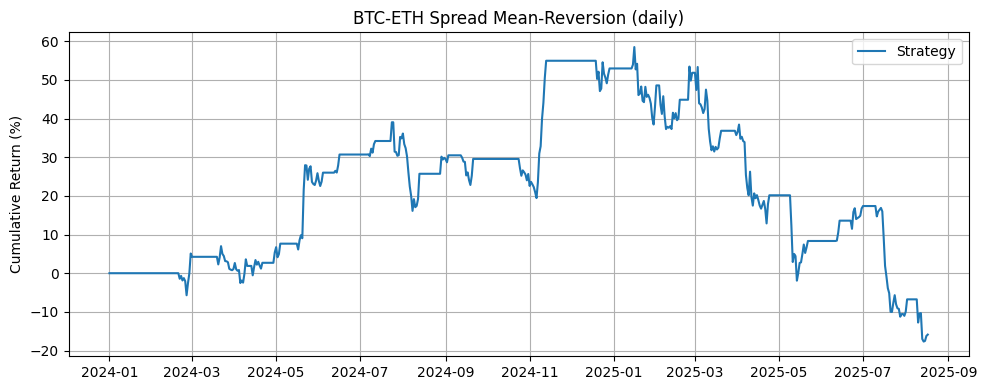

In [4]:
plt.figure(figsize=(10,4))
plt.plot(df_perf['date'], df_perf['cum_ret']*100, label='Strategy')
plt.title("BTC-ETH Spread Mean-Reversion (daily)")
plt.ylabel("Cumulative Return (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()